In [1]:
box = 'Box_n50_8_1400'
FIXED = {
         'f1':0.12,
         'd0':2.4,
        }
param_names = [ 'd1',
               'e0' ,'e1',
               'f0', 
               'g0','g1']
ndim = len(param_names)

In [2]:
def get_mass_function_plots(yerr_dict, params):
    i=0
    fig_axs = {}
    c_params = params | FIXED
    for a in N_data:

        fig1 = plt.figure(figsize =(12, 7))

        axs=[fig1.add_axes((0.2,0.4,.75,.6)), fig1.add_axes((0.2,0.0,.75,.4))]
        plt.subplots_adjust(wspace=0, hspace=0)
        Pk = mass_function.Pka[a]
        c_data = NvMs[a]

        Ms = M_data[a]
        N = N_data[a]
        edge_pairs = c_data['edge_pairs']

        edges = [edge[0] for edge in edge_pairs]
        edges += [edge_pairs[-1][1]]

        yerr = yerr_dict[a]
        dM = np.array([edges[1]-edges[0] for edges in edge_pairs])


        tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
#             print(tinker_eval_MCMC)

#             f_dndM_MCMC_LOG = interp1d(np.log10(M_numerics), tinker_eval_MCMC, kind='linear', bounds_error=False, fill_value=0.)
#             f_dndM_MCMC = lambda x:f_dndM_MCMC_LOG(np.log10(x))
        f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', bounds_error=False, fill_value=0.)

        tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1])[0] for edge in edge_pairs])



        axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')
        axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')

        edges = np.array(edges)
        axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
                   align='edge', fill=False, ec='black', label='Data')
        axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), align='edge', fill=False, ec='blue', label='Tinker')
        axs[1].errorbar(Ms, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='blue')

        y1 = 0.1*np.ones_like(N)
        y1 = np.append(y1, y1[-1])
        y1 = np.append(y1[0], y1)

        y2 = -0.1*np.ones_like(N)
        y2 = np.append(y2, y2[-1])
        y2 = np.append(y2[0], y2)

        c_Ms = np.append(Ms, edges[-1])
        c_Ms = np.append(edges[0], c_Ms)
        axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

        y1 = 0.01*np.ones_like(N)
        y1 = np.append(y1, y1[-1])
        y1 = np.append(y1[0], y1)

        y2 = -0.01*np.ones_like(N)
        y2 = np.append(y2, y2[-1])
        y2 = np.append(y2[0], y2)

        axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


        axs[0].set_xscale('log')
        axs[0].set_yscale('log')
        axs[0].legend(frameon=False)
        axs[0].set_ylabel('N')

        axs[1].set_xscale('log')
        axs[1].set_yscale('symlog', linthresh=1e-2)    
        axs[1].legend(frameon=False)
        axs[1].axhline(0, c='black')
        axs[1].set_ylabel('N')
        axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
        axs[1].set_ylabel(r'$\frac{N_{\rm Tinker}-N_{\rm data}}{N_{\rm data}} $')
        axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))
        i+=1

        axs[0].set_xlim((200*Mpart, np.max(edges)))
        axs[1].set_xlim((200*Mpart, np.max(edges)))
        axs[1].set_ylim((-1e1, 1e1))
        fig_axs[a] = [fig1, axs]
    return fig_axs

In [3]:
from utils import *
from massfunction import *

import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os
import emcee
import sys
import numpy as np
import pickle

In [4]:
cosmos_f = open('data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

In [5]:
cosmo = cosmo_params[box]
mass_function = MassFunction(cosmo)

In [6]:
h = cosmo['H0']/100

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

In [7]:
N_data = {}
M_data = {}
aux_data = {}
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline


vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm(NvMs.keys()):
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
    
    mass_function.compute_dlnsinvdM(a)

  0%|          | 0/16 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:60: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and ca

In [8]:
a_list = list(NvMs.keys())

from scipy.stats import poisson


M_numerics = np.logspace(np.log10(100*Mpart), 17, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

In [9]:
jack_covs = {a:jackknife[a][1] for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a: jack_covs[a] for a in jack_covs}

# Inverse of the weighted covariance matrix
inv_weighted_cov = {a:np.linalg.inv(weighted_cov[a]) for a in weighted_cov}  

scale_cov = {a:np.log(np.linalg.det(weighted_cov[a])) for a in weighted_cov}

In [10]:
def log_prior(param_values):
    #uniform prior
    params = dict(zip(param_names, param_values))
    params = params | FIXED
    for param in params.values():
        if(np.abs(param) >= 5):
            return -np.inf
    for a in N_data:
        d = mass_function.p(a, params['d0'], params['d1'])
        e = mass_function.p(a, params['e0'], params['e1'])
        f = mass_function.p(a, params['f0'], params['f1'])
        g = mass_function.p(a, params['g0'], params['g1'])
        ps = [d,e,f,g]
        for param in ps:
            if(param < 0 or param > 5):
                return -np.inf
    return 0

def log_prob(param_values):   
    """
    Calculates the probability of the given tinker parameters 
    
    Args:
        param_values (np.ndarray): Input array of shape (number of params).
        
    Returns:
        float: Resulting log probability
    """

    if(log_prior(param_values) == -np.inf):
        return -np.inf

    params = dict(zip(param_names, param_values))
    params = params | FIXED

    tinker_fs = {}
    
    for a in N_data:
        tinker_eval = [mass_function.tinker(a, M_c, params)*vol for M_c in M_numerics]
        f_dndlogM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
        tinker_fs[a] = f_dndlogM
        
    model_vals = {}
    for a in N_data:
        if(scaleToRedshift(a) >=2):
            continue
        model_vals[a] = np.array([quad(tinker_fs[a], edge_pair[0], edge_pair[1], epsabs=1e-1)[0]
            for edge_pair in NvMs[a]['edge_pairs']
        ])
    
    
    residuals = {a: model_vals[a]-N_data[a] for a in model_vals}
    log_probs = [ -0.5 * (np.dot(np.dot(residuals[a].T, inv_weighted_cov[a]), residuals[a]) + scale_cov[a]) 
                 for a in model_vals]
    if not np.isfinite(np.sum(log_probs)): 
        return -np.inf
    return np.sum(log_probs)

def log_likelihood(param_values):
    lp = log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)

In [11]:
guess = np.random.uniform(size=(len(param_names)))
while(not np.isfinite(log_likelihood(guess))):
    guess = np.random.uniform(size=(len(param_names)))


print('Starting ML Fit')
#Start by sampling with a maximum likelihood approach
from scipy import optimize as optimize
nll = lambda *args: -log_likelihood(*args)
result = optimize.minimize(nll, guess, method="Nelder-Mead", options={
    'maxiter': len(guess)*10000
})
result['param_names'] = param_names
print(box)
print(result)
print(result['x'])

Starting ML Fit
Box_n50_8_1400
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 26126.809252497987
             x: [-4.943e-02  9.410e-01  1.671e-01  4.565e-01  1.271e+00
                  1.214e-01]
           nit: 479
          nfev: 760
 final_simplex: (array([[-4.943e-02,  9.410e-01, ...,  1.271e+00,
                         1.214e-01],
                       [-4.945e-02,  9.410e-01, ...,  1.271e+00,
                         1.214e-01],
                       ...,
                       [-4.941e-02,  9.410e-01, ...,  1.271e+00,
                         1.214e-01],
                       [-4.949e-02,  9.410e-01, ...,  1.271e+00,
                         1.214e-01]]), array([ 2.613e+04,  2.613e+04,  2.613e+04,  2.613e+04,
                        2.613e+04,  2.613e+04,  2.613e+04]))
   param_names: ['d1', 'e0', 'e1', 'f0', 'g0', 'g1']
[-0.04943336  0.94099323  0.16710865  0.45650799  1.27130194  0.12139066]


In [12]:
MLE_params = dict(zip(param_names, result['x']))

/tmp/ipykernel_12384/2193824167.py:76: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')
/tmp/ipykernel_12384/2193824167.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1])[0] for edge in edge_pairs])


{0.25: [<Figure size 864x504 with 2 Axes>,
  [<Axes: title={'center': 'Box_n50_8_1400, a=0.25, z=3.00'}, ylabel='N'>,
   <Axes: xlabel='Mass $[h^{-1}M_\\odot]$', ylabel='$\\frac{N_{\\rm Tinker}-N_{\\rm data}}{N_{\\rm data}} $'>]],
 0.302679: [<Figure size 864x504 with 2 Axes>,
  [<Axes: title={'center': 'Box_n50_8_1400, a=0.30, z=2.30'}, ylabel='N'>,
   <Axes: xlabel='Mass $[h^{-1}M_\\odot]$', ylabel='$\\frac{N_{\\rm Tinker}-N_{\\rm data}}{N_{\\rm data}} $'>]],
 0.366459: [<Figure size 864x504 with 2 Axes>,
  [<Axes: title={'center': 'Box_n50_8_1400, a=0.37, z=1.73'}, ylabel='N'>,
   <Axes: xlabel='Mass $[h^{-1}M_\\odot]$', ylabel='$\\frac{N_{\\rm Tinker}-N_{\\rm data}}{N_{\\rm data}} $'>]],
 0.403224: [<Figure size 864x504 with 2 Axes>,
  [<Axes: title={'center': 'Box_n50_8_1400, a=0.40, z=1.48'}, ylabel='N'>,
   <Axes: xlabel='Mass $[h^{-1}M_\\odot]$', ylabel='$\\frac{N_{\\rm Tinker}-N_{\\rm data}}{N_{\\rm data}} $'>]],
 0.488191: [<Figure size 864x504 with 2 Axes>,
  [<Axes: title={

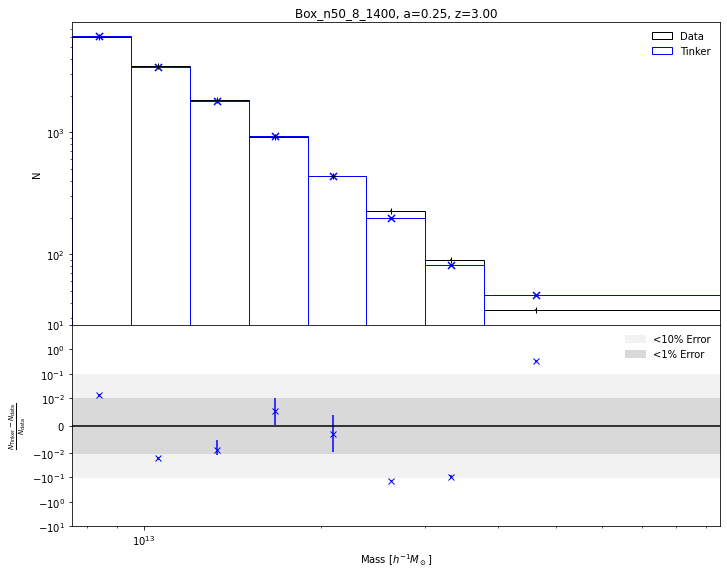

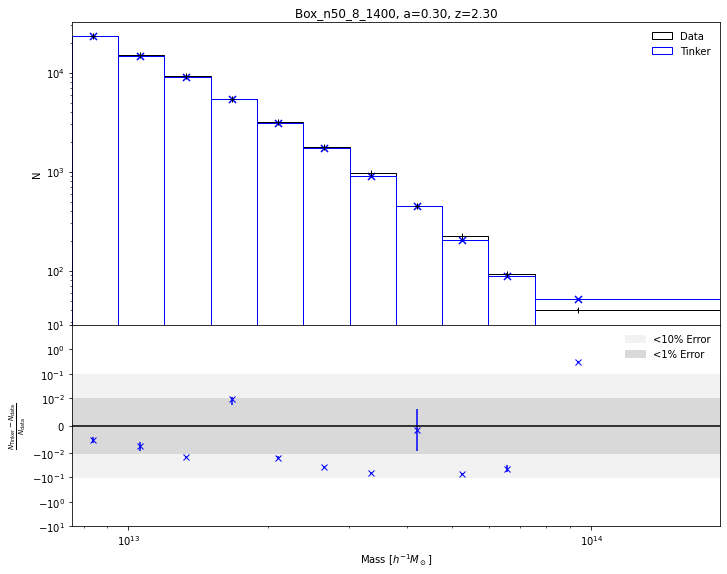

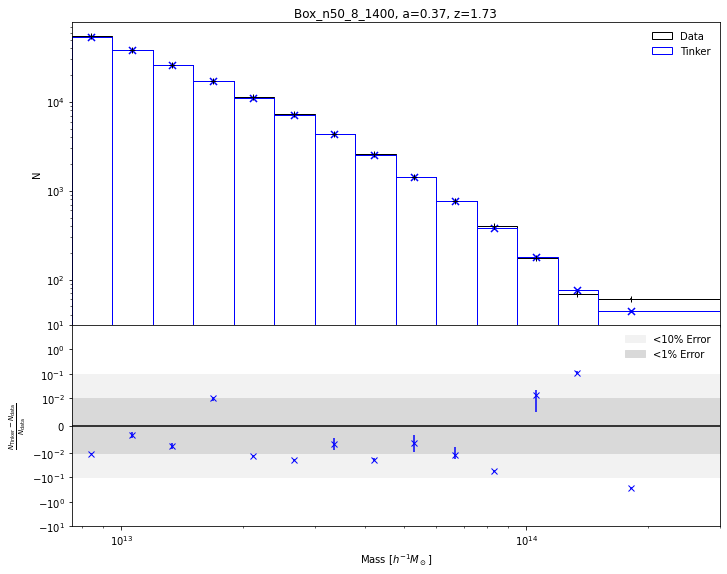

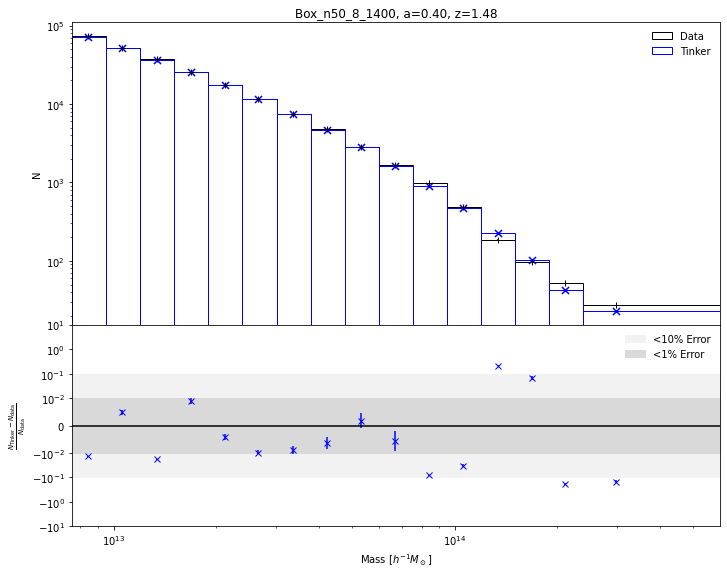

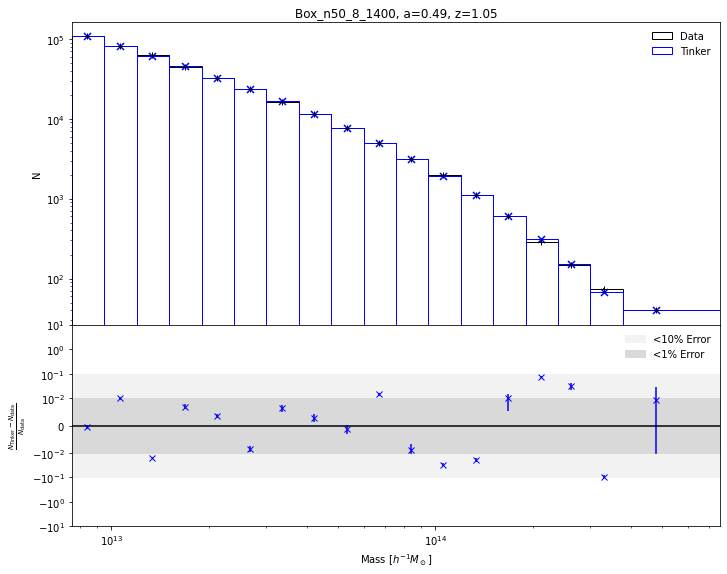

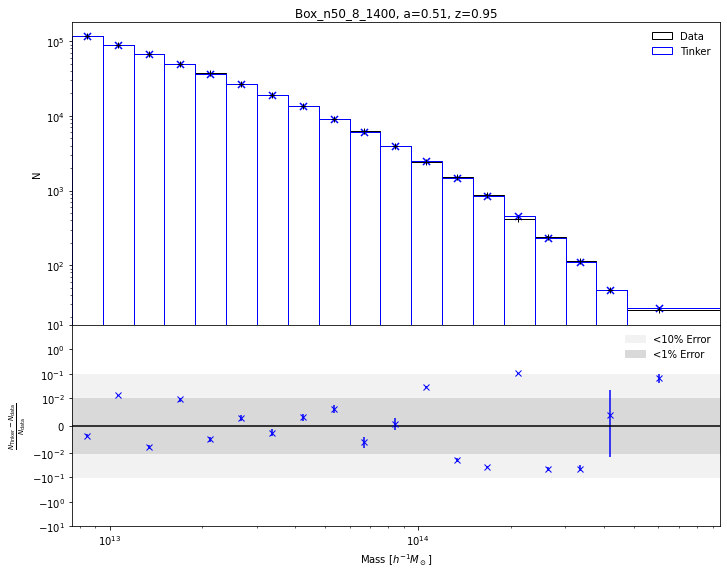

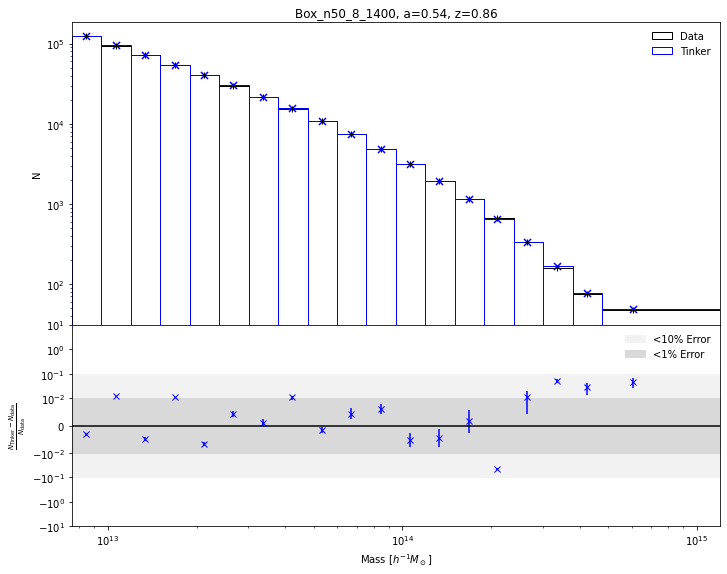

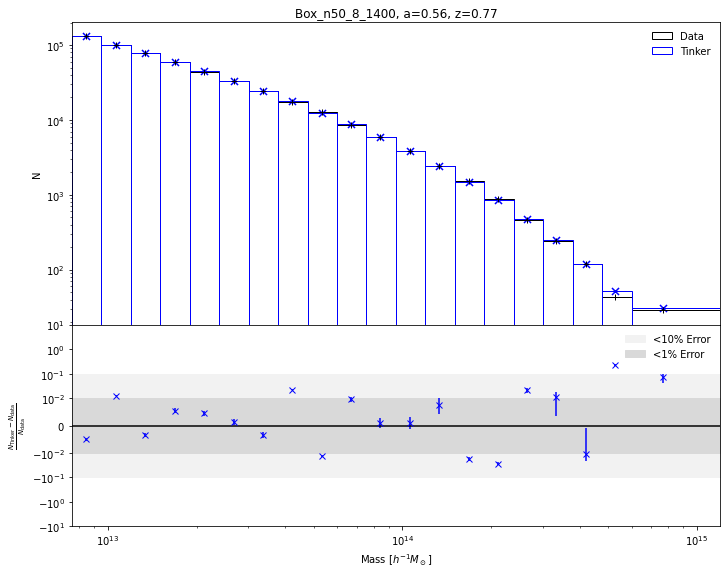

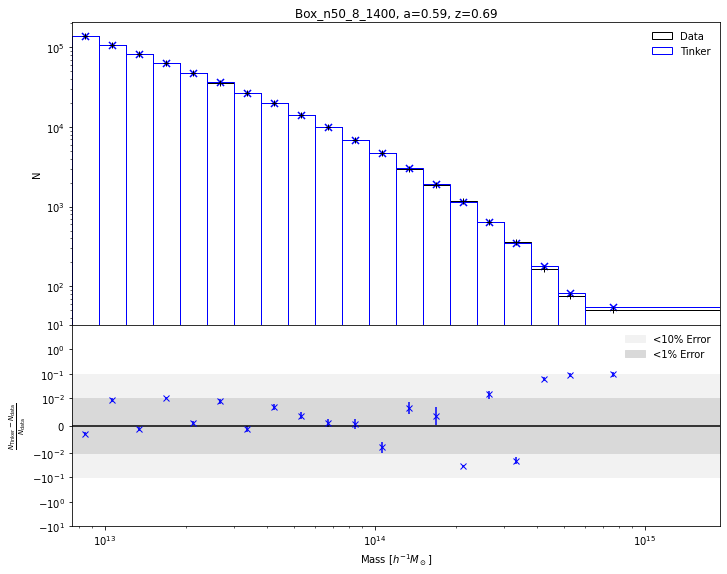

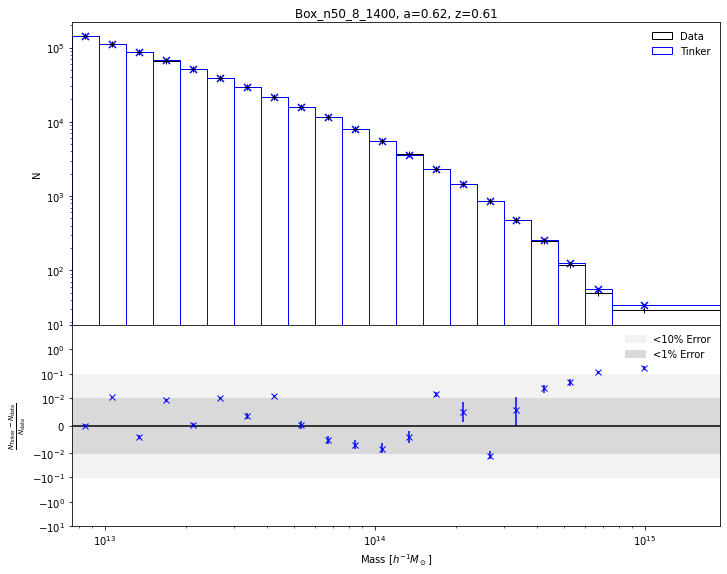

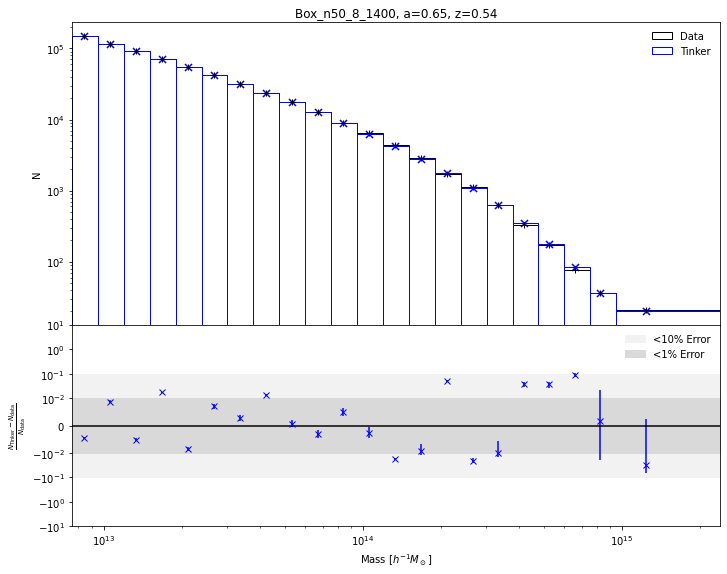

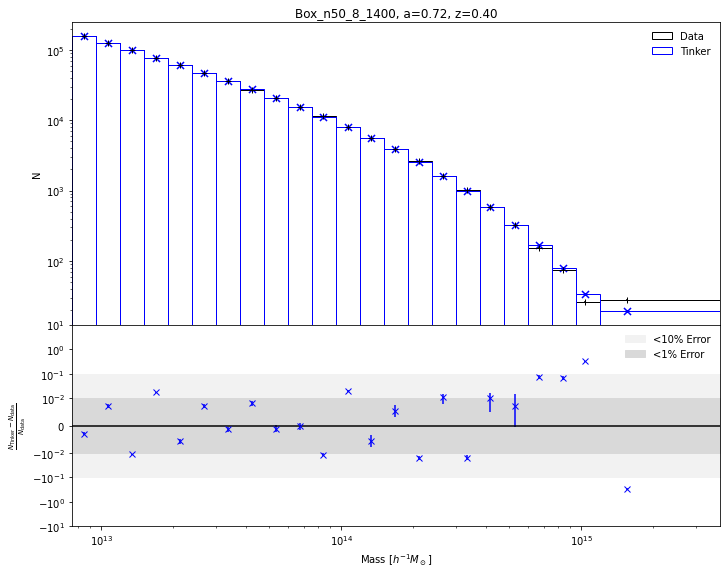

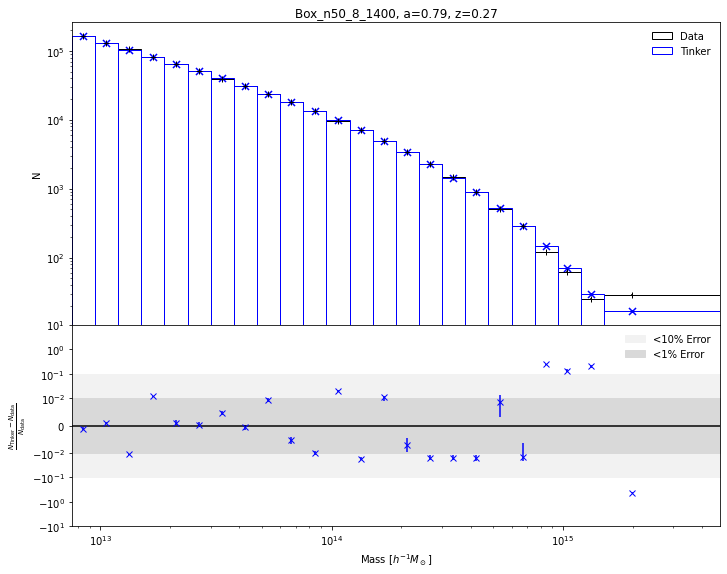

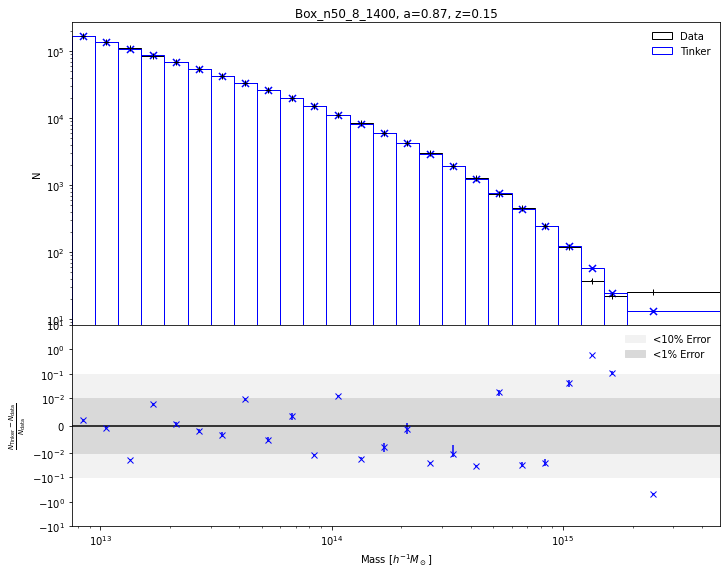

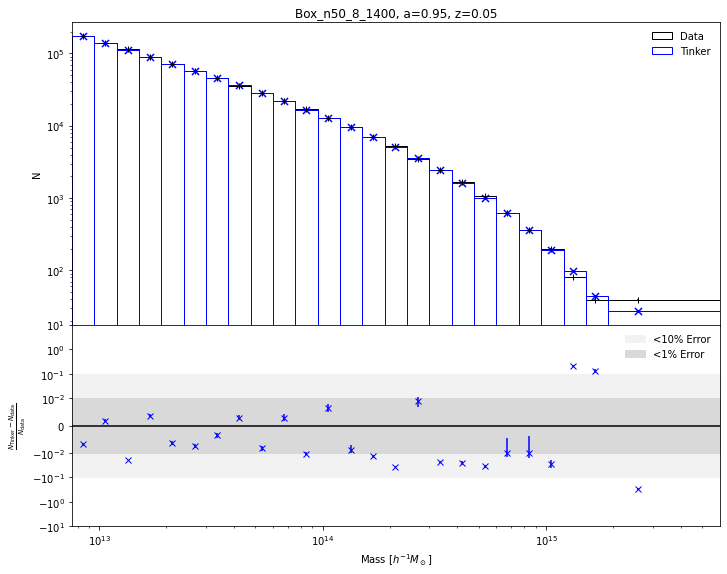

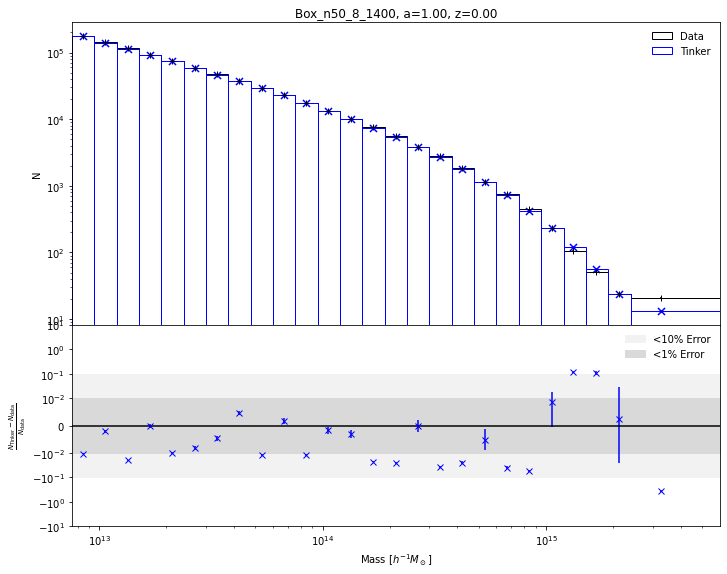

In [13]:
yerr_dict = {a:np.sqrt(np.diagonal(weighted_cov[a])) for a in weighted_cov} 
get_mass_function_plots(yerr_dict, MLE_params)

In [ ]:
result_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_MLFit.pkl'
result_f = open(result_fname, 'wb')
pickle.dump(result, result_f)
result_f.close()

In [14]:
nwalkers = 64
ndim = len(param_names)

initialpos = np.array([result['x'] for _ in range(nwalkers)]) + 1e-2 * np.random.normal(size=(nwalkers, ndim))


from multiprocessing import Pool

sampler = emcee.EnsembleSampler(
    nwalkers = nwalkers,
    ndim = ndim,
    log_prob_fn = log_likelihood,
    pool=Pool()
)

sampler.run_mcmc(initialpos, 1000, progress=True);



100%|██████████| 1000/1000 [25:01<00:00,  1.50s/it]


In [15]:
# sampler.run_mcmc(None, 1000, progress=True);


In [ ]:
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(box), "wb") as f:
    pickle.dump(sampler, f)

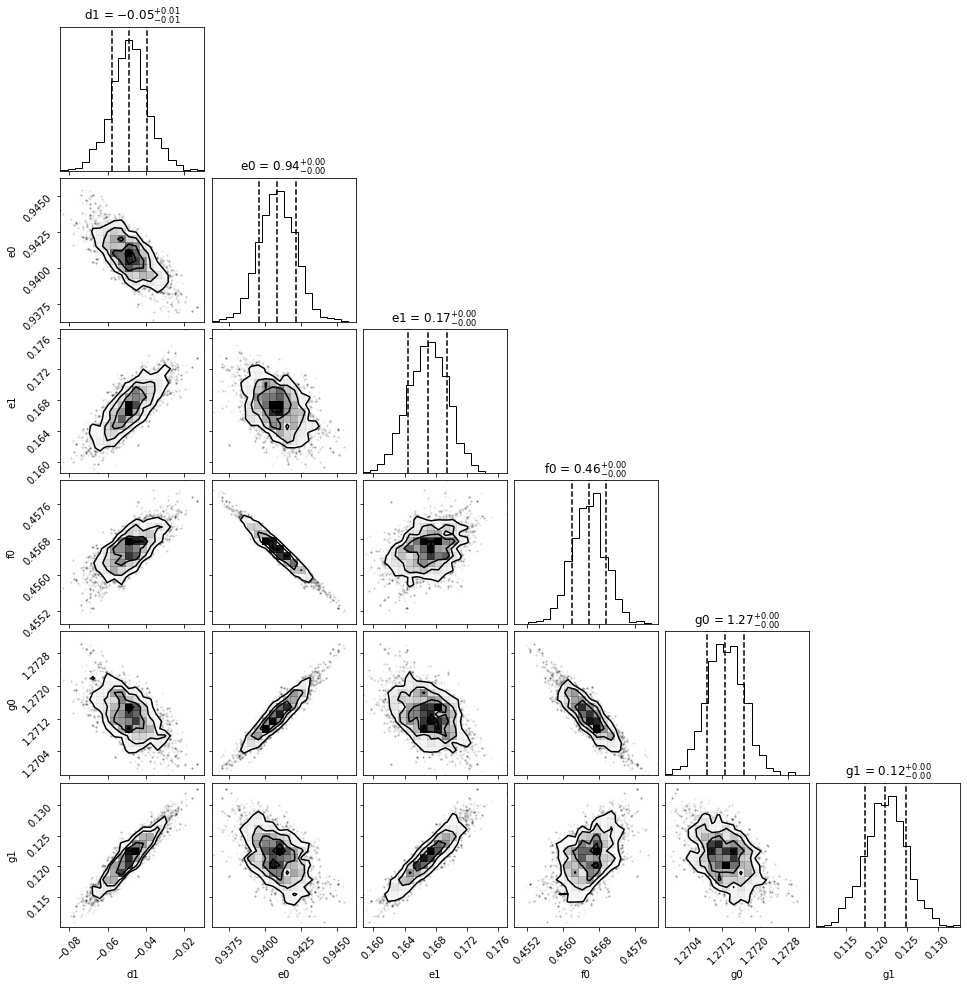

In [16]:
labels = param_names

import corner
samples = sampler.chain[:, 900:, :].reshape((-1, ndim))
final_param_vals = np.percentile(samples,  50,axis=0)
params_final = dict(zip(param_names, final_param_vals))
fig = corner.corner(samples, labels=labels, quantiles=[0.16, 0.5, 0.84],show_titles=True,)

plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_MCMC_corner.pdf'%(box), bbox_inches='tight')

(1000, 64, 6)


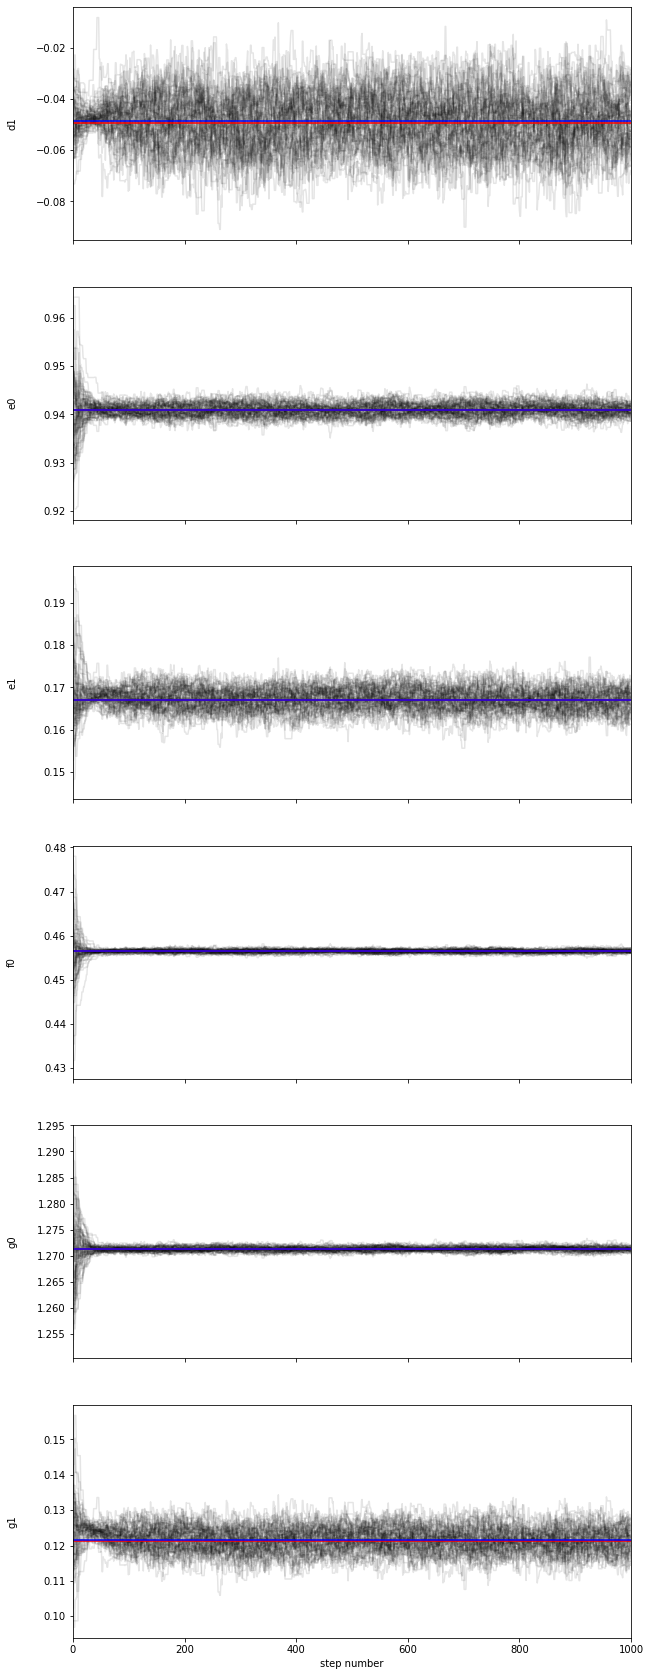

In [17]:
labels = param_names

fig, axes = plt.subplots(ndim, figsize=(10, 30), sharex=True)
samples = sampler.get_chain()
print(np.shape(samples))
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axhline(result['x'][i], color='red')
    ax.axhline(final_param_vals[i], color='blue')
axes[-1].set_xlabel("step number");

plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_MCMC_convergence.pdf'%(box), bbox_inches='tight')

In [18]:
params_final

{'d1': -0.04859684912397137,
 'e0': 0.9408363711074406,
 'e1': 0.16706002265840933,
 'f0': 0.4565830805083573,
 'g0': 1.2712713636518935,
 'g1': 0.12142405534515209}

/tmp/ipykernel_12384/2193824167.py:76: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')
/tmp/ipykernel_12384/2193824167.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1])[0] for edge in edge_pairs])


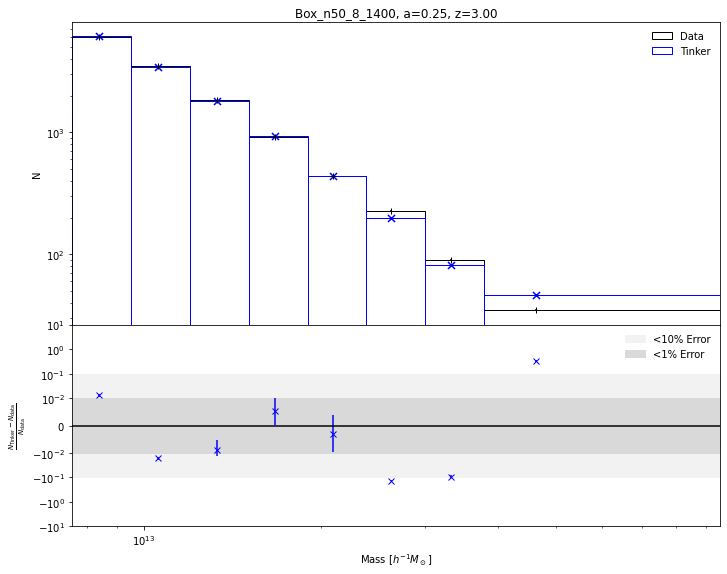

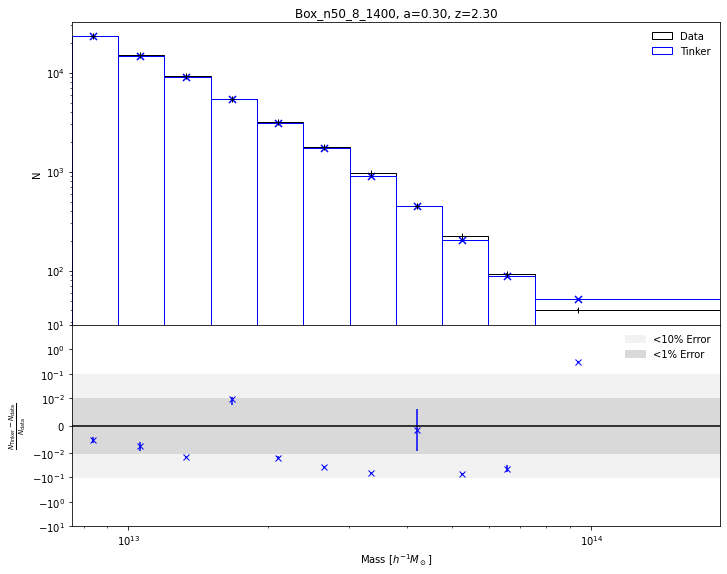

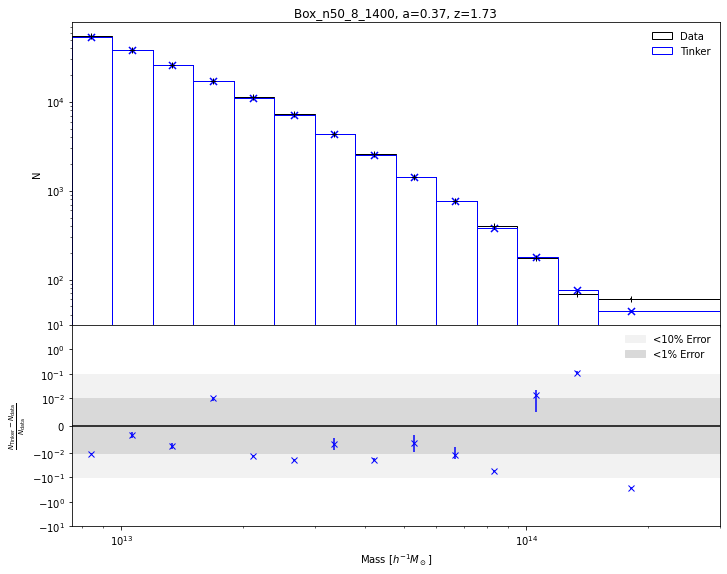

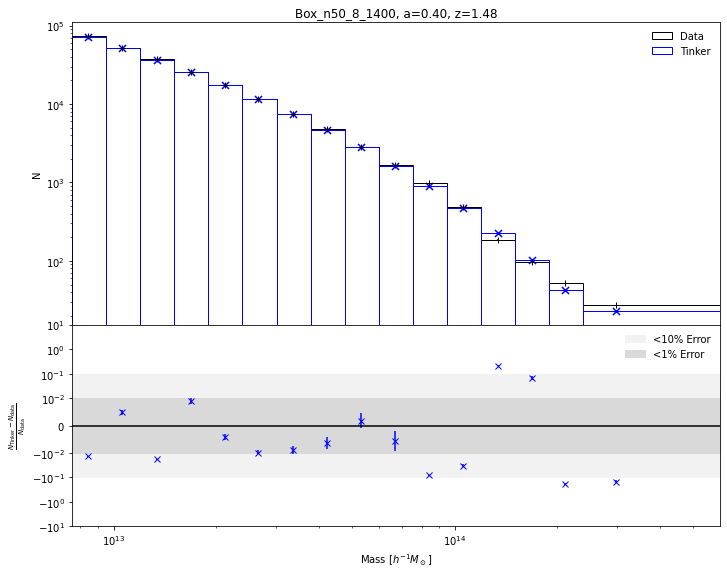

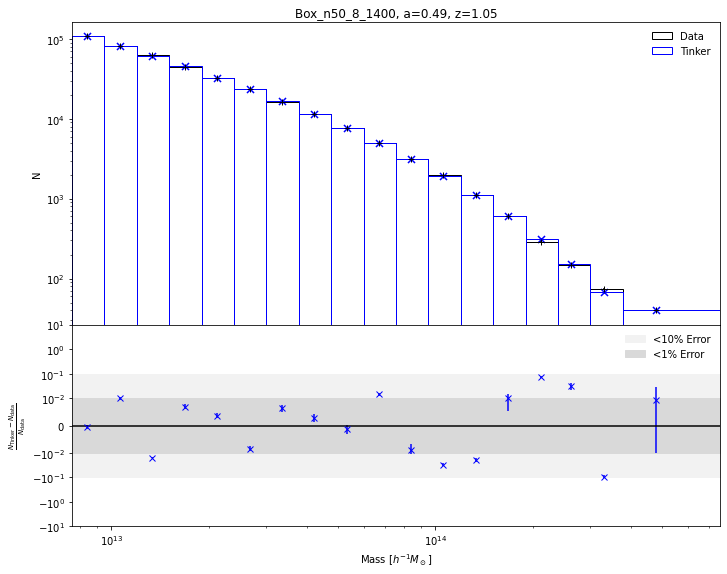

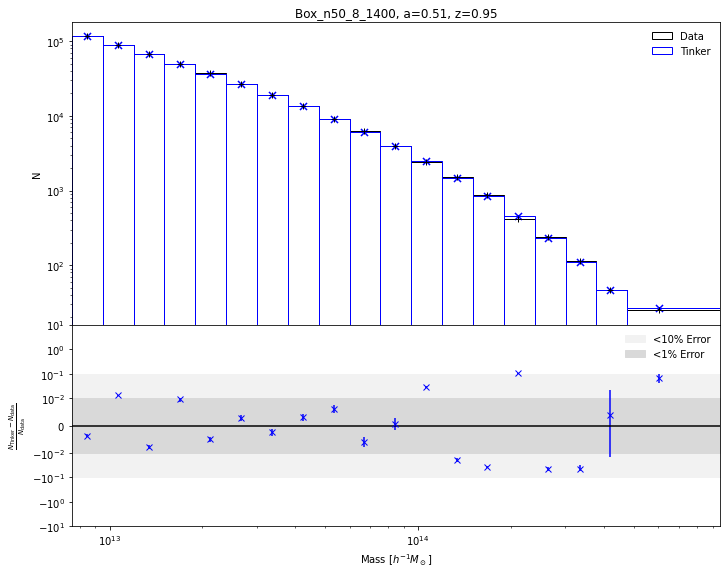

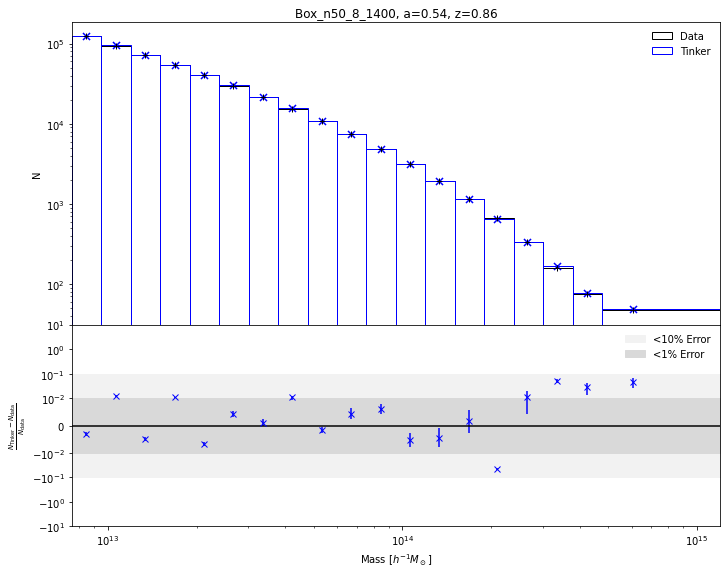

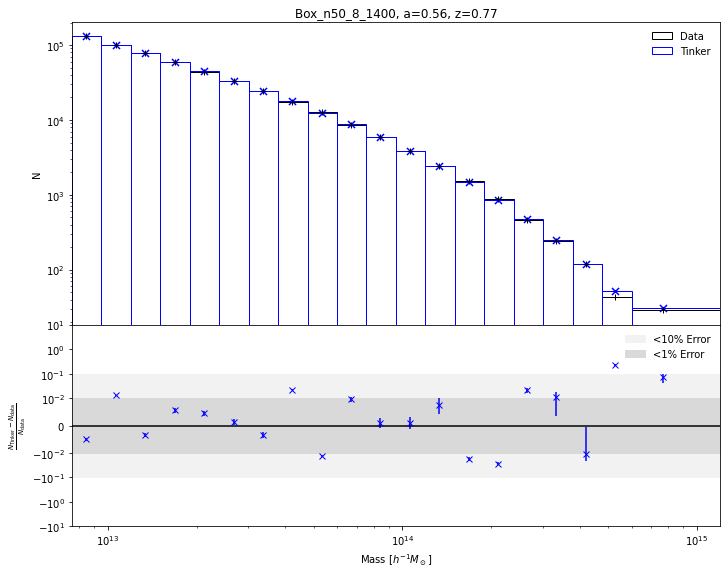

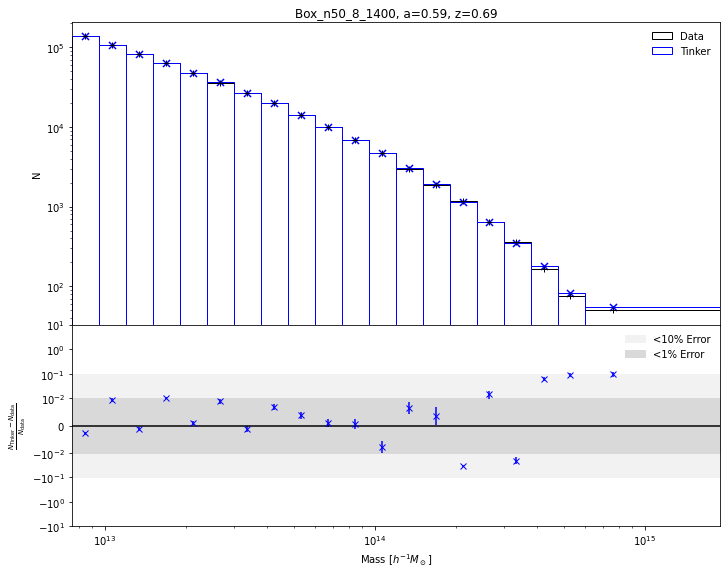

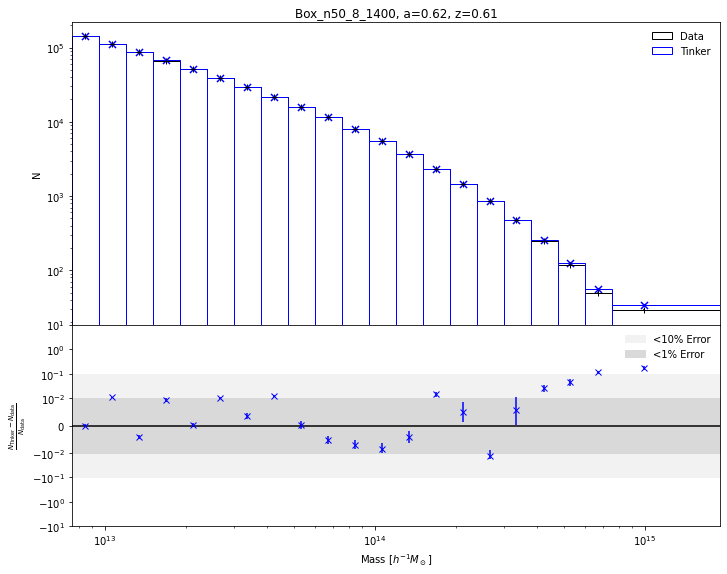

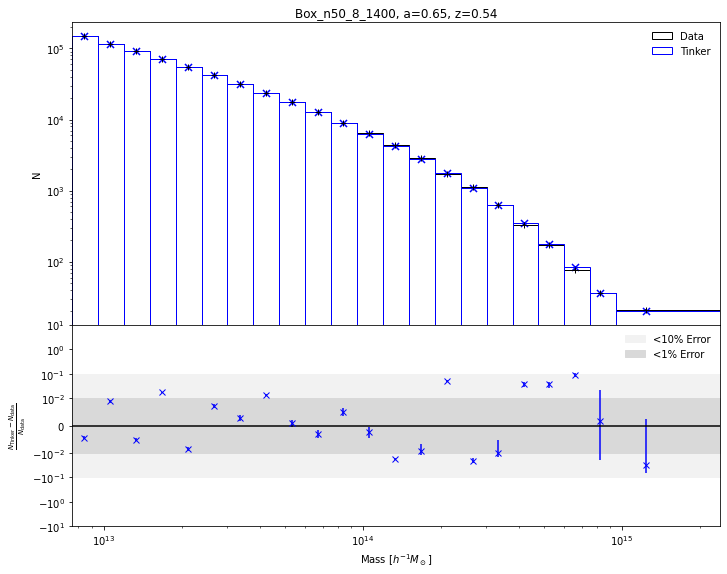

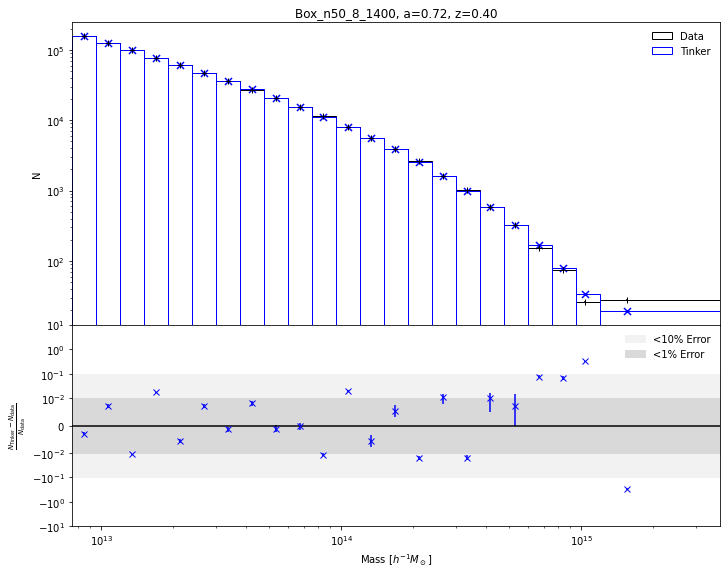

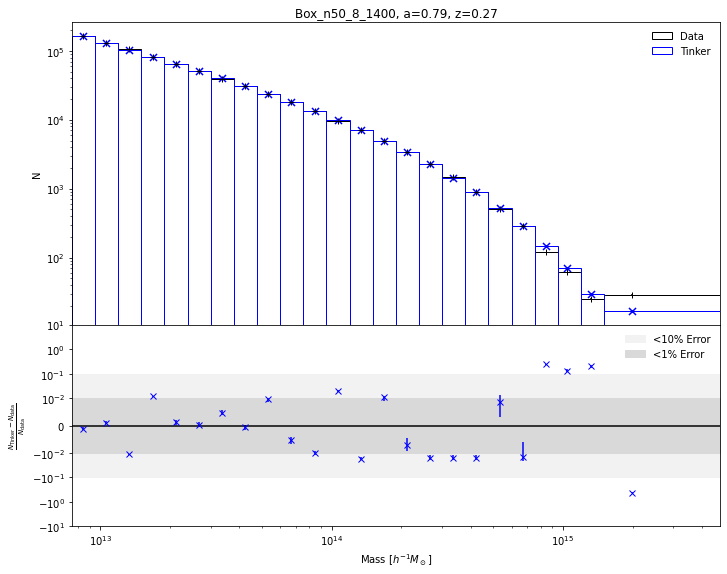

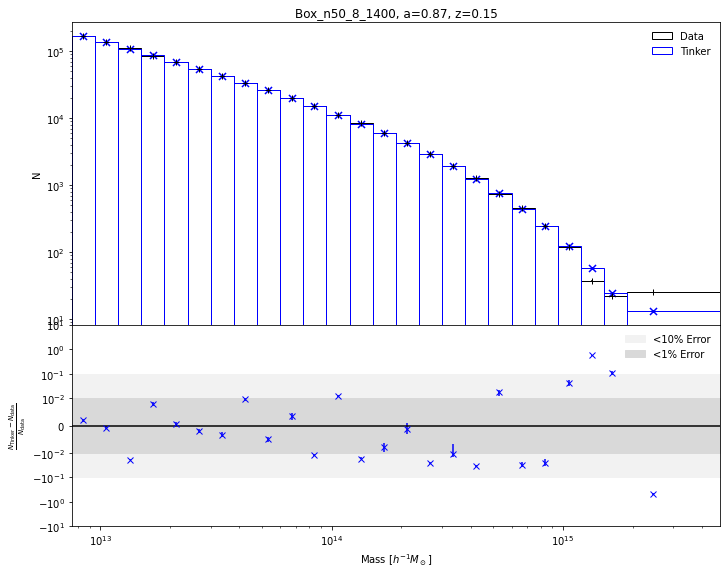

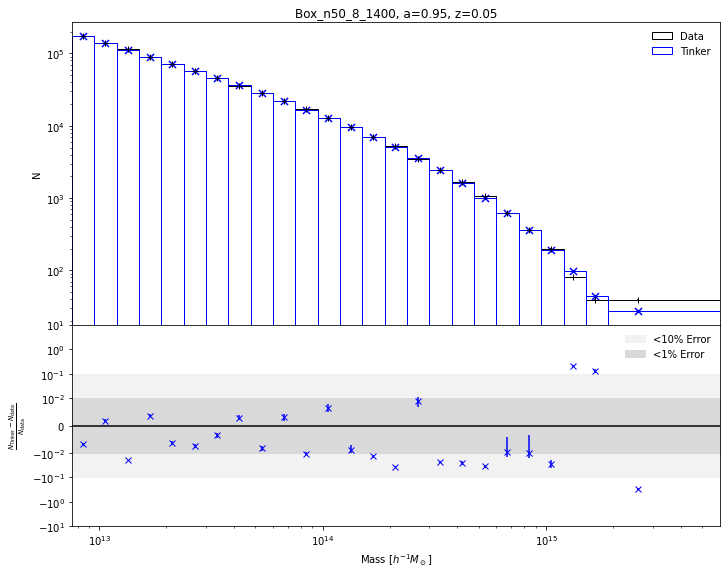

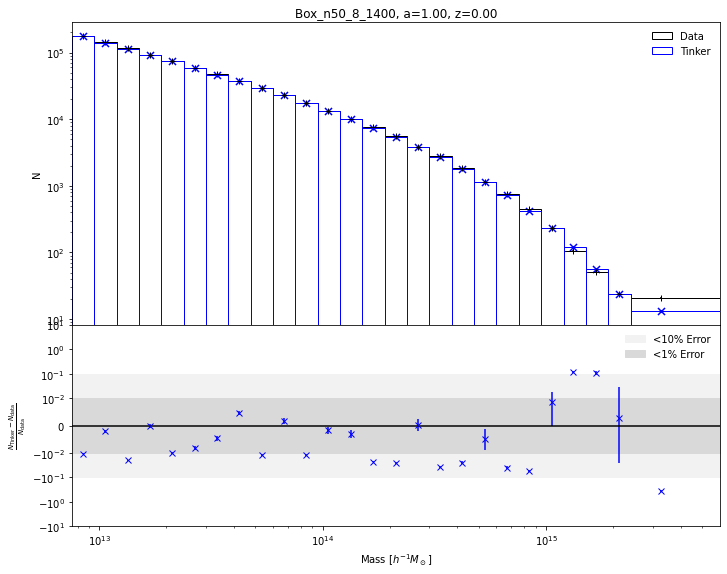

In [19]:
SUFFIX = ''
yerr_dict = {a:np.sqrt(np.diagonal(weighted_cov[a])) for a in weighted_cov} 
fig_axs = get_mass_function_plots(yerr_dict, params_final)
for (fig, a) in zip(fig_axs, N_data):
    fig_axs[fig][0].savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_fit_%.2f%s.pdf'%(box, a, SUFFIX), bbox_inches='tight')